In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_1228', 'test_1141', 'test_674', 'test_523', 'test_304', 'test_731', 'test_380', 'test_48', 'test_1272', 'test_835', 'test_299', 'test_25', 'test_27', 'test_497', 'test_31', 'test_596', 'test_557', 'test_923', 'test_1301', 'test_994', 'test_1133', 'test_1014', 'test_1114', 'test_848', 'test_1082', 'test_906', 'test_840', 'test_877', 'test_745', 'test_1041', 'test_146', 'test_88', 'test_948', 'test_467', 'test_344', 'test_891', 'test_987', 'test_311', 'test_121', 'test_913', 'test_1050', 'test_1000', 'test_726', 'test_1276', 'test_1121', 'test_929', 'test_922', 'test_597', 'test_760', 'test_35', 'test_893', 'test_442', 'test_667', 'test_706', 'test_94', 'test_1013', 'test_774', 'test_768', 'test_39', 'test_147', 'test_905', 'test_649', 'test_743', 'test_673', 'test_615', 'test_1036', 'test_902', 'test_790', 'test_1119', 'test_744', 'test_129', 'test_798', 'test_661', 'test_668', 'test_1047', 'test_964', 'test_177', 'test_1066', 'test_378', 'test_231', 'test_644', 'test_682', '

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_1019', 'test_796', 'test_809', 'test_412', 'test_1182', 'test_495', 'test_1283', 'test_1273', 'test_470', 'test_1261', 'test_742', 'test_1264', 'test_1217', 'test_653', 'test_1208', 'test_1177', 'test_530', 'test_652', 'test_647', 'test_522', 'test_477', 'test_927', 'test_447', 'test_51', 'test_1005', 'test_441', 'test_800', 'test_841', 'test_1099', 'test_1058', 'test_1125', 'test_1275', 'test_136', 'test_511', 'test_863', 'test_386', 'test_838', 'test_89', 'test_951', 'test_1064', 'test_1198', 'test_556', 'test_665', 'test_499', 'test_885', 'test_291', 'test_715', 'test_1152', 'test_904', 'test_807', 'test_910', 'test_135', 'test_735', 'test_1170', 'test_1200', 'test_1167', 'test_803', 'test_1078', 'test_396', 'test_206', 'test_578', 'test_107', 'test_1248', 'test_187', 'test_259', 'test_173', 'test_959', 'test_397', 'test_697', 'test_892', 'test_1024', 'test_446', 'test_16', 'test_431', 'test_912', 'test_1279', 'test_759', 'test_1285', 'test_145', 'test_1227', 'test_308', 

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [30]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [52]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [ ]:
#find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

In [37]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [44]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [45]:
print(ft_intersection)

['test_1019', 'test_796', 'test_809', 'test_412', 'test_1182', 'test_495', 'test_1283', 'test_1273', 'test_470', 'test_1261', 'test_742', 'test_1264', 'test_1217', 'test_653', 'test_1208', 'test_1177', 'test_530', 'test_652', 'test_647', 'test_522', 'test_477', 'test_927', 'test_447', 'test_51', 'test_1005', 'test_441', 'test_800', 'test_841', 'test_1099', 'test_1058', 'test_1125', 'test_1275', 'test_136', 'test_511', 'test_863', 'test_386', 'test_838', 'test_89', 'test_951', 'test_1064', 'test_1198', 'test_556', 'test_665', 'test_499', 'test_885', 'test_291', 'test_715', 'test_1152', 'test_904', 'test_807', 'test_910', 'test_135', 'test_735', 'test_1170', 'test_1200', 'test_1167', 'test_803', 'test_1078', 'test_396', 'test_206', 'test_578', 'test_107', 'test_1248', 'test_187', 'test_259', 'test_173', 'test_959', 'test_397', 'test_697', 'test_892', 'test_1024', 'test_446', 'test_16', 'test_431', 'test_912', 'test_1279', 'test_759', 'test_1285', 'test_145', 'test_1227', 'test_308', 'tes

In [ ]:
#find_overlap(ft_intersection, baseline_dict, s3c_dict, correct_baseline_clusters, incorrect_s3c_clusters, False)

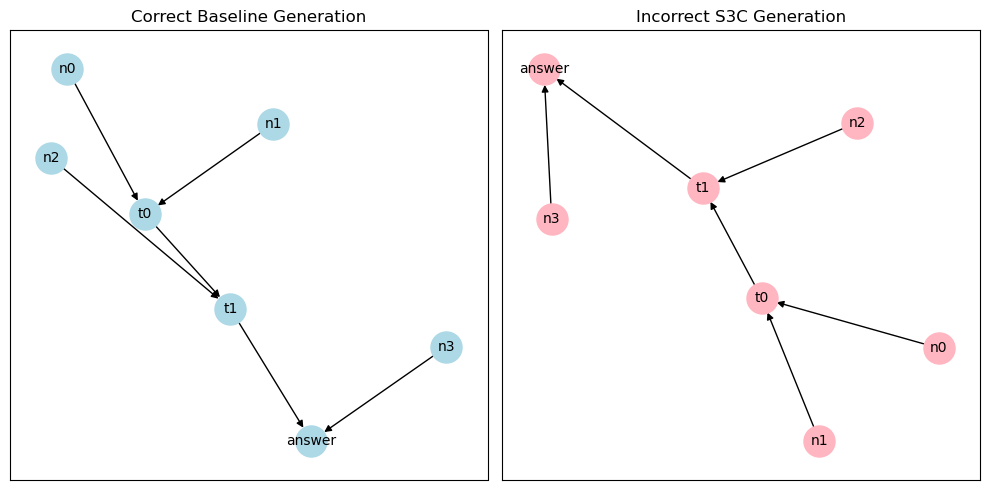

In [54]:
import networkx as nx

# Create an empty directed graph
graph_correct = nx.DiGraph()
graph_incorrect = nx.DiGraph()

# Correct Baseline Generation
graph_correct.add_node("n0")
graph_correct.add_node("n1")
graph_correct.add_node("n2")
graph_correct.add_node("n3")
graph_correct.add_node("t0")
graph_correct.add_node("t1")
graph_correct.add_node("answer")

graph_correct.add_edge("n0", "t0")
graph_correct.add_edge("n1", "t0")
graph_correct.add_edge("t0", "t1")
graph_correct.add_edge("n2", "t1")
graph_correct.add_edge("t1", "answer")
graph_correct.add_edge("n3", "answer")

# Incorrect S3C Generation
graph_incorrect.add_node("n0")
graph_incorrect.add_node("n1")
graph_incorrect.add_node("n2")
graph_incorrect.add_node("n3")
graph_incorrect.add_node("t0")
graph_incorrect.add_node("t1")
graph_incorrect.add_node("answer")

graph_incorrect.add_edge("n0", "t0")
graph_incorrect.add_edge("n1", "t0")
graph_incorrect.add_edge("t0", "t1")
graph_incorrect.add_edge("n2", "t1")
graph_incorrect.add_edge("t1", "answer")
graph_incorrect.add_edge("n3", "answer")

# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(graph_correct, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(graph_incorrect, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()


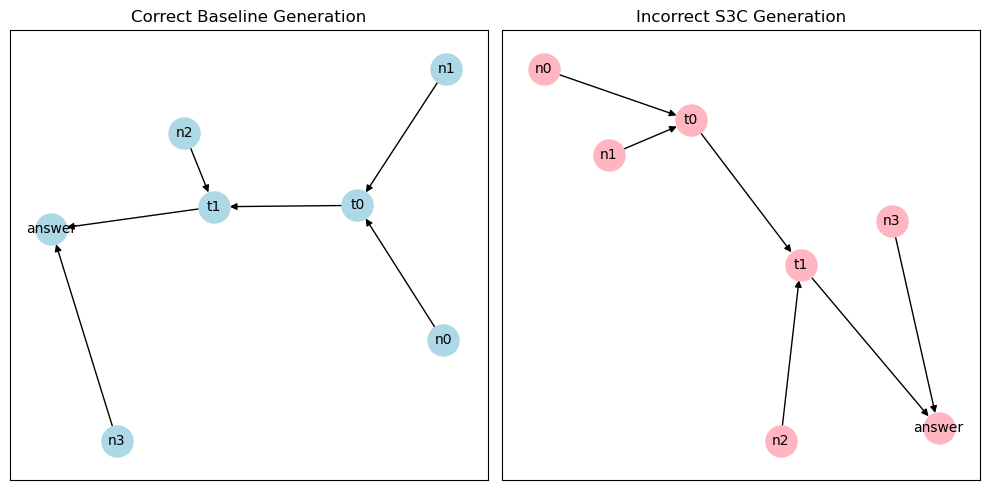

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            graph.add_node(var)

            # Find dependencies using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            for dep in dependencies:
                graph.add_edge(dep, var)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)

s3c_graph = parse_string_to_graph(incorrect_string)


# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()



In [82]:
import networkx as nx

# Create graphs (graph_correct and graph_incorrect) as shown previously

# Check for graph isomorphism
is_isomorphic = nx.is_isomorphic(graph_correct, graph_incorrect)
print("Graphs are isomorphic:", is_isomorphic)

# Check for subgraph isomorphism
subgraph_match = nx.algorithms.isomorphism.vf2userfunc.GraphMatcher(graph_correct, graph_incorrect)
subgraph_match_results = list(subgraph_match.subgraph_monomorphisms_iter())
print("Subgraph isomorphism matches:")
#pprint(subgraph_match_results)


Graphs are isomorphic: True
Subgraph isomorphism matches:


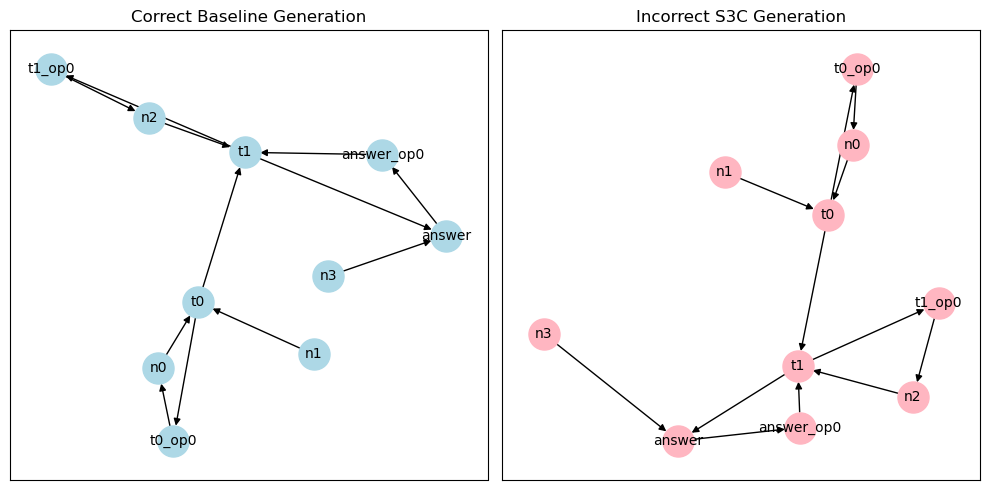

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            graph.add_node(var)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, dep in enumerate(dependencies):
                graph.add_edge(dep, var)
                if i < len(operators):
                    op_node = f"{var}_op{i}_{operators[i]}"
                    graph.add_node(op_node, label=operators[i])
                    graph.add_edge(var, op_node)
                    graph.add_edge(op_node, dep)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)

s3c_graph = parse_string_to_graph(incorrect_string)


# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()